# (Split 7/3)

Epoch 1/100
13/13 [==============================] - 2s 41ms/step - loss: 0.0486 - val_loss: 0.0160
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0094 - val_loss: 0.0154
Epoch 3/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0213
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0125
Epoch 5/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0040 - val_loss: 0.0120
Epoch 6/100
13/13 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 0.0103
Epoch 7/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0040 - val_loss: 0.0127
Epoch 8/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0038 - val_loss: 0.0141
Epoch 9/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0101
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0036 - val_loss: 0.0087

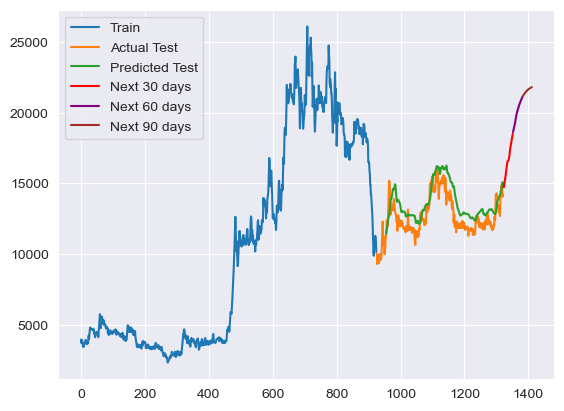

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Dự báo giá trị 90 ngày trong tương lai
last_90_days = price_scaled[-90:]
next_90_days = []
for i in range(90):
    x = last_90_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_90_days = np.append(last_90_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(data), len(data)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
# Plot next 90 days predictions with different colors
plt.plot(next_90_days_df.index[:30], next_90_days_df[:30], label='Next 30 days', color='red')
plt.plot(next_90_days_df.index[30:60], next_90_days_df[30:60], label='Next 60 days', color='purple')
plt.plot(next_90_days_df.index[60:], next_90_days_df[60:], label='Next 90 days', color='brown')

plt.legend()
plt.show()

# (Split 8/2)

Epoch 1/100
15/15 [==============================] - 2s 41ms/step - loss: 0.0526 - val_loss: 0.0100
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 4/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 5/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 8/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 9/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 10/100
15/15 [==============================] - 0s 29ms/step - loss: 0.0043 - val_loss: 0.0025

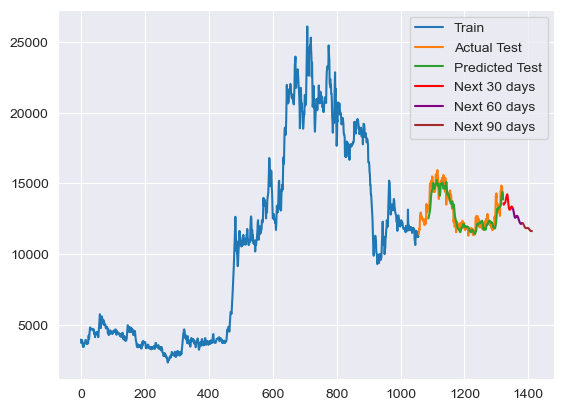

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Dự báo giá trị 90 ngày trong tương lai
last_90_days = price_scaled[-90:]
next_90_days = []
for i in range(90):
    x = last_90_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_90_days = np.append(last_90_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(data), len(data)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
# Plot next 90 days predictions with different colors
plt.plot(next_90_days_df.index[:30], next_90_days_df[:30], label='Next 30 days', color='red')
plt.plot(next_90_days_df.index[30:60], next_90_days_df[30:60], label='Next 60 days', color='purple')
plt.plot(next_90_days_df.index[60:], next_90_days_df[60:], label='Next 90 days', color='brown')

plt.legend()
plt.show()

# (Split 9/1)

Epoch 1/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0354 - val_loss: 0.0019
Epoch 2/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 10/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0042 - val_loss: 0.0017

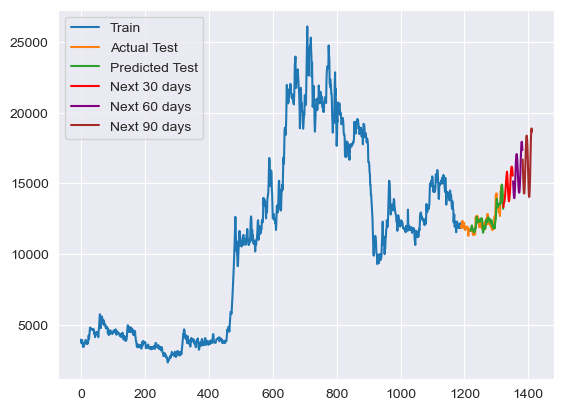

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.9)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Dự báo giá trị 90 ngày trong tương lai
last_90_days = price_scaled[-90:]
next_90_days = []
for i in range(90):
    x = last_90_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_90_days = np.append(last_90_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print(next_90_days)

from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(data), len(data)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
# Plot next 90 days predictions with different colors
plt.plot(next_90_days_df.index[:30], next_90_days_df[:30], label='Next 30 days', color='red')
plt.plot(next_90_days_df.index[30:60], next_90_days_df[30:60], label='Next 60 days', color='purple')
plt.plot(next_90_days_df.index[60:], next_90_days_df[60:], label='Next 90 days', color='brown')

plt.legend()
plt.show()